# Model Run
Version 1: original

## Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


from model_model import JudgeNetwork
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import MelSpecTransform, DS_Tools, Normalizer
from model_dataset import SingleRecDataset as ThisDataset
from model_filter import XpassFilter
from paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = ""
else: 
    ts = str(get_timestamp())

train_name = "judge-low"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
print(f"{train_name}-{ts}")
mk(model_save_dir)

judge-low-1125163922


In [4]:
stop_epoch = "149"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
save_valacc_name = "valacc.hst"
save_trainacc_name = "trainacc.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_accs = ListRecorder(os.path.join(model_save_dir, save_valacc_name))
train_accs = ListRecorder(os.path.join(model_save_dir, save_trainacc_name))

## Prepare Dataset

In [6]:
mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                            n_fft=TrainingConfigs.N_FFT, 
                            n_mels=TrainingConfigs.N_MELS, norm=Normalizer.norm_strip_mvn)
ds = ThisDataset(train_cut_audio_, os.path.join(src_, "guide_mod.csv"), transform=mytrans)

if not READ: 
    use_len = int(0.01 * len(ds))
    remain_len = len(ds) - use_len
    use_ds, remain_ds = random_split(ds, [use_len, remain_len])

    train_len = int(0.8 * len(use_ds))
    valid_len = len(use_ds) - train_len

    # Randomly split the dataset into train and validation sets
    train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
else: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

    train_ds = torch.utils.data.Subset(ds, train_ds_indices)
    valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [7]:
train_num, valid_num, ds.mapper.token_num()

(27947, 6987, 39)

In [8]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
(xx_pad, xx_lens), seg = sample_data

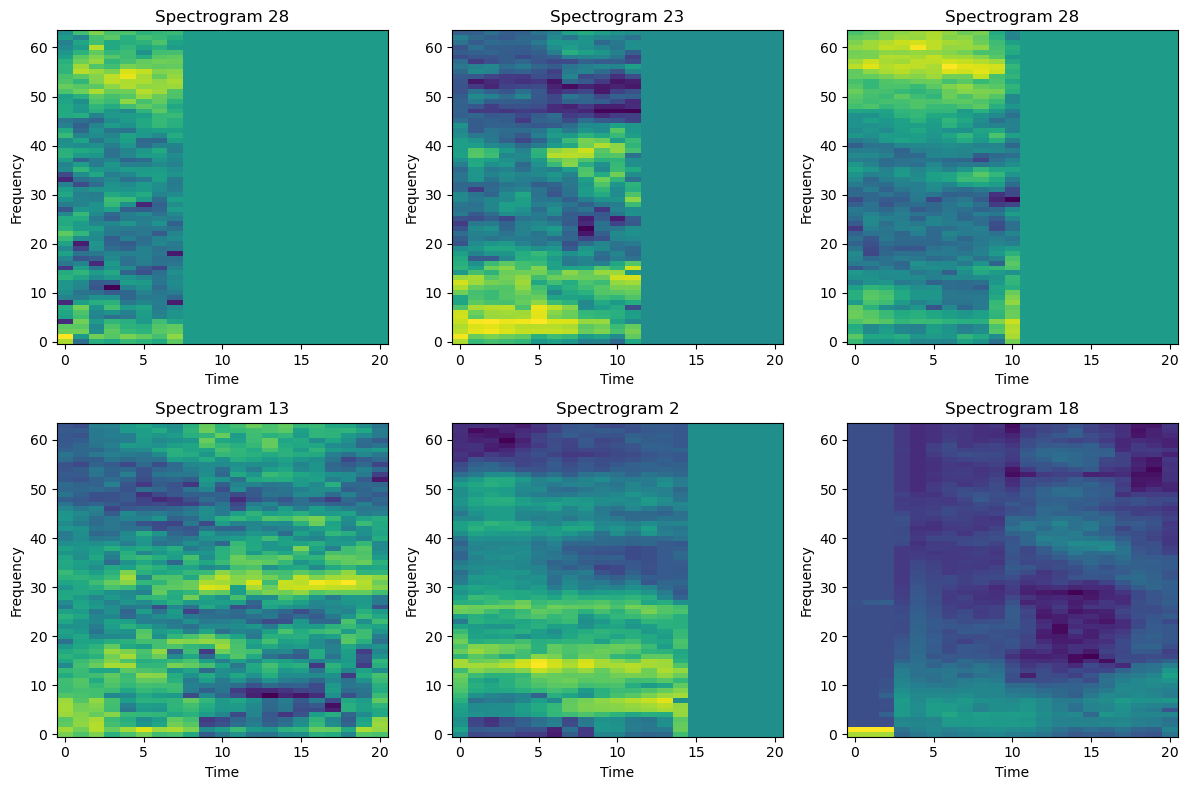

In [9]:
# Set the random seed for reproducibility
random.seed(101)
# Generate six random indices
random_indices = random.sample(range(len(xx_pad)), 6)

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    segment = seg[idx]
    
    ax = axes[i]
    ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram {segment}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Init Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=TrainingConfigs.N_MELS, 
        lin_in_size_1=128, 
        lin_in_size_2=64, 
        lin_out_size_2=ds.mapper.token_num()
    )

model = JudgeNetwork(
    dimconf=dimconf
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Load Model if READ

In [11]:
def draw_learning_curve_and_accuracy(losses, accs, epoch="", best_val=None, save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    train_losses, valid_losses, best_val_loss = losses
    train_accs, valid_accs = accs

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    ax2.plot(train_accs, label='Train')
    ax2.plot(valid_accs, label='Valid')
    if best_val: 
        ax2.axhline(y=best_val, color='r', linestyle='--', label=f'Best: {best_val:.3f}')
    ax2.set_title('Learning Curve Accuracy' + f" {epoch}")
    ax2.legend(loc="lower right")

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [12]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [13]:
best_valid_loss = 1e9
best_valid_loss_epoch = 0

In [14]:
EPOCHS = 100
BASE = 0

In [15]:
def train(best_valid_loss, best_valid_loss_epoch): 
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_correct = 0
        train_total = 0
        for idx, ((x, x_lens), y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x, x_lens)
            loss = criterion(y_hat, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            pred = model.predict_on_output(y_hat)

            train_total += y_hat.size(0)
            train_correct += (pred == y).sum().item()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_accs.append(train_correct / train_total)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_correct = 0
        valid_total = 0
        for idx, ((x, x_lens), y) in enumerate(valid_loader):
            x = x.to(device)
            y = torch.tensor(y, device=device)

            y_hat = model(x, x_lens)
            loss = criterion(y_hat, y)
            valid_loss += loss.item()

            pred = model.predict_on_output(y_hat)

            valid_total += y_hat.size(0)
            valid_correct += (pred == y).sum().item()

            draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_correct / valid_total)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         accs=(train_accs.get(), valid_accs.get()), 
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()

    return best_valid_loss, best_valid_loss_epoch

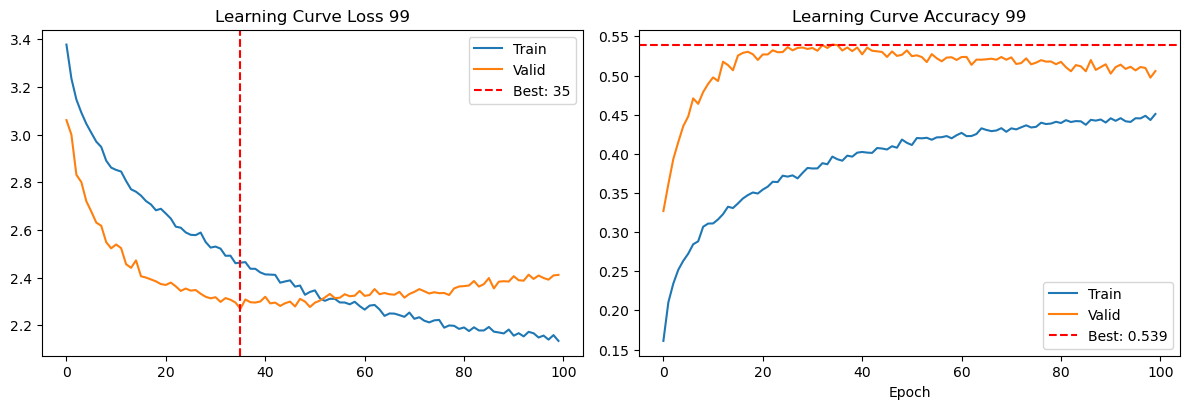

<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

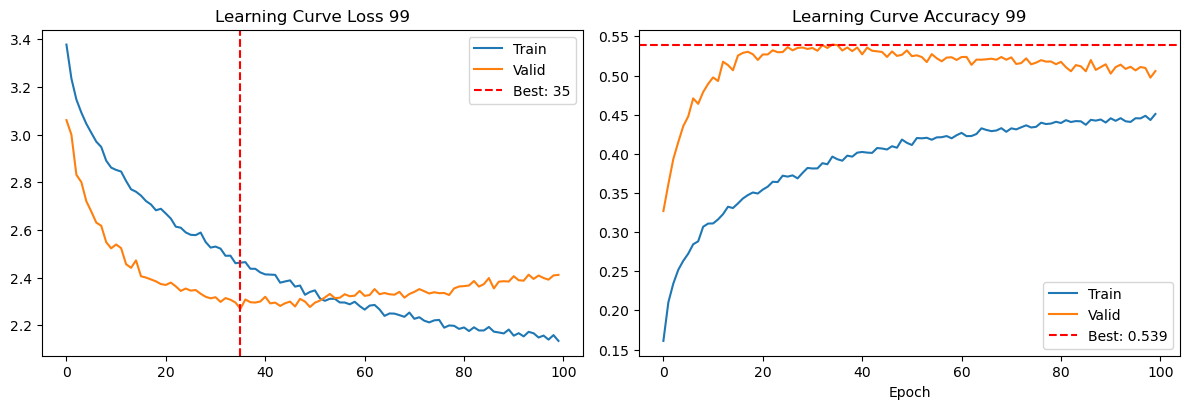

In [16]:
if __name__ == "__main__": 
    best_valid_loss, best_valid_loss_epoch = train(best_valid_loss, best_valid_loss_epoch)
    draw_learning_curve_and_accuracy(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                    accs=(train_accs.get(), valid_accs.get()), 
                                    epoch=str(BASE + EPOCHS - 1), 
                                    best_val=valid_accs.get()[best_valid_loss_epoch], 
                                    save=True, 
                                    save_name=f"{model_save_dir}/vis.png")